# 03. Model Benchmarks

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the processed data from previous notebook
print("Loading processed data...")
with open('../data/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

Loading processed data...


In [3]:
# Extract all the necessary variables
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
test_ID = data['test_ID']
numeric_features = data['numeric_features']
categorical_features = data['categorical_features']


In [4]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2051, 23)
Test data shape: (878, 23)


## 0. Feature Selection

In [7]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2051, 23)
Test data shape: (878, 23)


In [8]:
# 1. Feature Selection for Linear Models
print("\n=== FEATURE SELECTION ===")

# Create dictionary to store different feature sets
feature_sets = {}


=== FEATURE SELECTION ===


In [9]:
# Option 1: Use correlation analysis to identify important features
# Calculate correlation with target variable
target_correlations = X_train[numeric_features].corrwith(y_train).abs().sort_values(ascending=False)
print("Top 15 numeric features by correlation with sale price:")
print(target_correlations.head(15))

Top 15 numeric features by correlation with sale price:
overall_qual                0.822775
overall_qual2               0.812052
log_total_sf                0.806347
living_area_qual            0.805706
total_sf                    0.774016
neighborhood_price_level    0.740609
log_gr_liv_area             0.721359
exter_qual_num              0.690334
kitchen_qual_num            0.681551
garage_cars                 0.667723
total_bathrooms             0.659341
bsmt_qual_num               0.632110
house_age                   0.624614
year_built                  0.624449
qual_cond                   0.614251
dtype: float64


In [10]:
# Option 2: Use feature importance from Ridge model to select features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Create preprocessing for Ridge model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Create and fit the pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=10.0))
])
ridge_pipeline.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = (
    numeric_features +
    list(ridge_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

# Get coefficients and create importance DataFrame
ridge_coef = ridge_pipeline.named_steps['ridge'].coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(ridge_coef)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 15 features by Ridge importance:")
print(feature_importance.head(15))


Top 15 features by Ridge importance:
                     Feature  Importance
4               log_total_sf    0.142030
3                   total_sf    0.083152
18                 qual_cond    0.076092
2            log_gr_liv_area    0.065801
28      neighborhood_Crawfor    0.062462
32      neighborhood_GrnHill    0.062351
39       neighborhood_NWAmes    0.054362
8                  house_age    0.053526
5   neighborhood_price_level    0.050983
14              log_lot_area    0.050253
33       neighborhood_IDOTRR    0.049156
25      neighborhood_BrkSide    0.048799
49      neighborhood_Veenker    0.047534
45      neighborhood_SawyerW    0.045882
43        neighborhood_SWISU    0.035466


In [11]:
# Feature Set 2: Top features based on Ridge importance
# Get top 20 features from ridge importance
top_ridge_features = feature_importance['Feature'].head(20).tolist()

# For features from one-hot encoding, extract original feature names
# E.g., from "neighborhood_NWAmes" to "neighborhood"
original_cat_features = set()
for f in feature_importance['Feature']:
    for cat in categorical_features:
        if f.startswith(cat + '_'):
            original_cat_features.add(cat)
            break

# Filter top ridge features to get numeric features
top_ridge_numeric = [f for f in numeric_features if f in top_ridge_features]

# Add top categorical features (original names, not one-hot encoded versions)
# Sort by highest importance of any encoded version
top_ridge_categorical_original = []
if len(categorical_features) > 0:  # Only if we have categorical features
    # For each original categorical feature, find its highest coefficient
    cat_max_importance = {}
    for cat in original_cat_features:
        # Find all one-hot encoded features for this category
        encoded_features = [f for f in feature_importance['Feature'] if f.startswith(cat + '_')]
        if encoded_features:
            # Get the maximum importance among all encoded features
            max_importance = feature_importance[
                feature_importance['Feature'].isin(encoded_features)
            ]['Importance'].max()
            cat_max_importance[cat] = max_importance
    
    # Sort categorical features by their maximum importance
    sorted_cats = sorted(cat_max_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Take top categorical features (up to 5)
    top_ridge_categorical_original = [cat for cat, _ in sorted_cats[:5] if cat in categorical_features]

# Store the second feature set - handle case with no categorical features
all_ridge_features = top_ridge_numeric.copy()
if top_ridge_categorical_original:
    all_ridge_features.extend(top_ridge_categorical_original)

feature_sets['ridge_selected'] = {
    'numeric_features': top_ridge_numeric,
    'categorical_features': top_ridge_categorical_original,
    'X_train': X_train[all_ridge_features],
    'X_test': X_test[all_ridge_features]
}

In [12]:
# Feature Set 3: Manual selection of top features

# selected_features = ['overall_qual2',
#  'neighborhood_price_level',
#  'log_total_sf',
#  'living_area_qual',
#  'log_lot_area',
#  'kitchen_qual_num',
#  'total_bathrooms',
#  'bsmt_qual_num',
#  'exter_qual_num',
#  'has_fireplace',
#  'garage_cars',
#  'house_age',
#  'central_air_num'
# ]

selected_features = [
    'overall_qual2',         # Overall quality 
    'log_gr_liv_area',       # Log of living area
    'log_total_sf',              # Total square footage
    'neighborhood_price_level', # Neighborhood price level
    'house_age',             # Age of the house
    'total_bathrooms',       # Total bathrooms
    'garage_cars',           # Garage capacity
    'kitchen_qual_num',      # Kitchen quality
    'exter_qual_num',        # Exterior quality
    'living_area_qual',      # Living area quality
    'bsmt_qual_num',         # Basement quality
    'log_lot_area',          # Log of lot area
    'has_fireplace',         # Has fireplace indicator
    'remod_age',             # Years since remodeling
    'central_air_num',       # Central air indicator
]

# Check if all selected features exist in the dataset
missing_features = [feat for feat in selected_features if feat not in X_train.columns]
if missing_features:
    print(f"Warning: These selected features are missing from the dataset: {missing_features}")
    # Remove missing features from selection
    selected_features = [feat for feat in selected_features if feat in X_train.columns]

# Categorize manual features
manual_numeric = [f for f in selected_features if f in numeric_features]
manual_categorical = [f for f in selected_features if f in categorical_features]

# Store the third feature set
feature_sets['manual_selected'] = {
    'numeric_features': manual_numeric,
    'categorical_features': manual_categorical,
    'X_train': X_train[selected_features],
    'X_test': X_test[selected_features]
}

# Print summary of feature sets
for name, feature_set in feature_sets.items():
    print(f"\nFeature set: {name}")
    print(f"Number of features: {len(feature_set['numeric_features']) + len(feature_set['categorical_features'])}")
    print(f"Numeric features: {len(feature_set['numeric_features'])}")
    print(f"Categorical features: {len(feature_set['categorical_features'])}")



Feature set: ridge_selected
Number of features: 11
Numeric features: 10
Categorical features: 1

Feature set: manual_selected
Number of features: 15
Numeric features: 15
Categorical features: 0


## 1. Processing Pipeline

In [13]:
preprocessing_pipelines = {}

for name, feature_set in feature_sets.items():
    # For numerical features: impute and scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # For categorical features: impute and one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    transformers = [('num', numeric_transformer, feature_set['numeric_features'])]
    
    # Only add categorical transformer if there are categorical features
    if len(feature_set['categorical_features']) > 0:
        transformers.append(('cat', categorical_transformer, feature_set['categorical_features']))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    preprocessing_pipelines[name] = preprocessor


## 2. Train-Validation Split for each feature set

In [14]:
train_val_splits = {}

for name, feature_set in feature_sets.items():
    X_train_set = feature_set['X_train']
    
    X_train_main, X_val, y_train_main, y_val = train_test_split(
        X_train_set, 
        y_train,
        test_size=0.2,
        random_state=42
    )
    
    train_val_splits[name] = {
        'X_train_main': X_train_main,
        'X_val': X_val,
        'y_train_main': y_train_main,
        'y_val': y_val,
        'X_train_full': X_train_set,
        'X_test': feature_set['X_test']
    }
    
    print(f"\nFeature set: {name}")
    print(f"Training subset shape: {X_train_main.shape}")
    print(f"Validation subset shape: {X_val.shape}")



Feature set: ridge_selected
Training subset shape: (1640, 11)
Validation subset shape: (411, 11)

Feature set: manual_selected
Training subset shape: (1640, 15)
Validation subset shape: (411, 15)


## 3. Defining Model Benchmark

In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge Regression (alpha=10.0)': Ridge(alpha=10.0),
    'Ridge Regression (alpha=100.0)': Ridge(alpha=100.0),
    'Lasso Regression (alpha=0.001)': Lasso(alpha=0.001),
    'Lasso Regression (alpha=0.01)': Lasso(alpha=0.01),
    'Lasso Regression (alpha=0.1)': Lasso(alpha=0.1),
    'ElasticNet (alpha=0.01, l1_ratio=0.5)': ElasticNet(alpha=0.01, l1_ratio=0.5)
}

## 4. Benchmark Models

In [16]:
all_results = {}

for feature_set_name, feature_set_data in train_val_splits.items():
    print(f"\n===== Benchmarking for feature set: {feature_set_name} =====")
    
    results = {}
    X_train_main = feature_set_data['X_train_main']
    X_val = feature_set_data['X_val']
    y_train_main = feature_set_data['y_train_main']
    y_val = feature_set_data['y_val']
    X_train_full = feature_set_data['X_train_full']
    
    for name, model in models.items():
        print(f"\nEvaluating: {name}")
        
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessing_pipelines[feature_set_name]),
            ('model', model)
        ])
        
        # Fit on training subset
        pipeline.fit(X_train_main, y_train_main)
        
        #***
        # Evaluate on validation set
        val_pred_log = pipeline.predict(X_val)
        
        # Back-transform predictions to original scale
        val_pred = np.expm1(val_pred_log)
        y_val_orig = np.expm1(y_val)
        
        # Calculate metrics on original scale
        val_rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))
        val_mae = mean_absolute_error(y_val_orig, val_pred)
        val_r2 = r2_score(y_val_orig, val_pred)
        
        print(f"  - Validation RMSE (original scale): ${val_rmse:.2f}")
        print(f"  - Validation MAE (original scale): ${val_mae:.2f}")
        print(f"  - Validation R²: {val_r2:.4f}")

        # Define custom scoring function for back-transformed values
        def rmse_on_original_scale(estimator, X, y_log):
            y_pred_log = estimator.predict(X)
            y_orig = np.expm1(y_log)
            y_pred_orig = np.expm1(y_pred_log)
            return -np.sqrt(mean_squared_error(y_orig, y_pred_orig))
        
        # Use the custom scorer in cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=kf,
            scoring=rmse_on_original_scale
        )
        
        cv_rmse = -cv_scores.mean()
        cv_std = cv_scores.std()
        
        print(f" - 5-Fold CV RMSE: ${cv_rmse:.2f} (±${cv_std:.2f})")
        
        # Store results
        results[name] = {
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'cv_rmse': cv_rmse,
            'cv_std': cv_std,
            'pipeline': pipeline
        }
    
    all_results[feature_set_name] = results



===== Benchmarking for feature set: ridge_selected =====

Evaluating: Linear Regression
  - Validation RMSE (original scale): $24769.28
  - Validation MAE (original scale): $16397.18
  - Validation R²: 0.8967
 - 5-Fold CV RMSE: $38281.33 (±$26154.34)

Evaluating: Ridge Regression (alpha=1.0)
  - Validation RMSE (original scale): $24299.80
  - Validation MAE (original scale): $16328.02
  - Validation R²: 0.9006
 - 5-Fold CV RMSE: $38167.15 (±$25979.92)

Evaluating: Ridge Regression (alpha=10.0)
  - Validation RMSE (original scale): $23902.59
  - Validation MAE (original scale): $16080.58
  - Validation R²: 0.9038
 - 5-Fold CV RMSE: $37648.80 (±$25458.99)

Evaluating: Ridge Regression (alpha=100.0)
  - Validation RMSE (original scale): $23037.50
  - Validation MAE (original scale): $15743.58
  - Validation R²: 0.9107
 - 5-Fold CV RMSE: $36317.51 (±$24455.95)

Evaluating: Lasso Regression (alpha=0.001)
  - Validation RMSE (original scale): $23798.89
  - Validation MAE (original scale): $

## 5. Summarized Results and Best Model Selection

In [17]:
print("\n===== OVERALL RESULTS =====")

# Create a summary DataFrame for CV RMSE across all feature sets and models
summary_data = []

for feature_set, results in all_results.items():
    for model_name, metrics in results.items():
        summary_data.append({
            'Feature Set': feature_set,
            'Model': model_name,
            'CV RMSE': metrics['cv_rmse'],
            'CV STD': metrics['cv_std'],
            'Validation RMSE': metrics['val_rmse'],
            'Validation R²': metrics['val_r2']
        })

summary_df = pd.DataFrame(summary_data)

# Display and sort by CV RMSE
print("\nAll models ranked by Cross-Validation RMSE:")
ranked_models = summary_df.sort_values('CV RMSE')
print(ranked_models[['Feature Set', 'Model', 'CV RMSE', 'Validation RMSE', 'Validation R²']])

# Find the overall best model
best_model_row = ranked_models.iloc[0]
best_feature_set = best_model_row['Feature Set']
best_model_name = best_model_row['Model']
best_model = all_results[best_feature_set][best_model_name]['pipeline']

print(f"\nBEST MODEL OVERALL:")
print(f"Feature Set: {best_feature_set}")
print(f"Model: {best_model_name}")
print(f"CV RMSE: ${best_model_row['CV RMSE']:.2f}")
print(f"Validation RMSE: ${best_model_row['Validation RMSE']:.2f}")
print(f"Validation R²: {best_model_row['Validation R²']:.4f}")


===== OVERALL RESULTS =====

All models ranked by Cross-Validation RMSE:
        Feature Set                                  Model       CV RMSE  \
11  manual_selected         Ridge Regression (alpha=100.0)  30744.075574   
15  manual_selected  ElasticNet (alpha=0.01, l1_ratio=0.5)  30972.291183   
13  manual_selected          Lasso Regression (alpha=0.01)  31092.234878   
12  manual_selected         Lasso Regression (alpha=0.001)  31380.627328   
10  manual_selected          Ridge Regression (alpha=10.0)  31774.551941   
9   manual_selected           Ridge Regression (alpha=1.0)  32055.615403   
8   manual_selected                      Linear Regression  32092.299986   
5    ridge_selected          Lasso Regression (alpha=0.01)  35384.329714   
7    ridge_selected  ElasticNet (alpha=0.01, l1_ratio=0.5)  35552.523586   
3    ridge_selected         Ridge Regression (alpha=100.0)  36317.508609   
4    ridge_selected         Lasso Regression (alpha=0.001)  37262.135742   
2    ridge_sel

## 6. Model Comparison Visualization

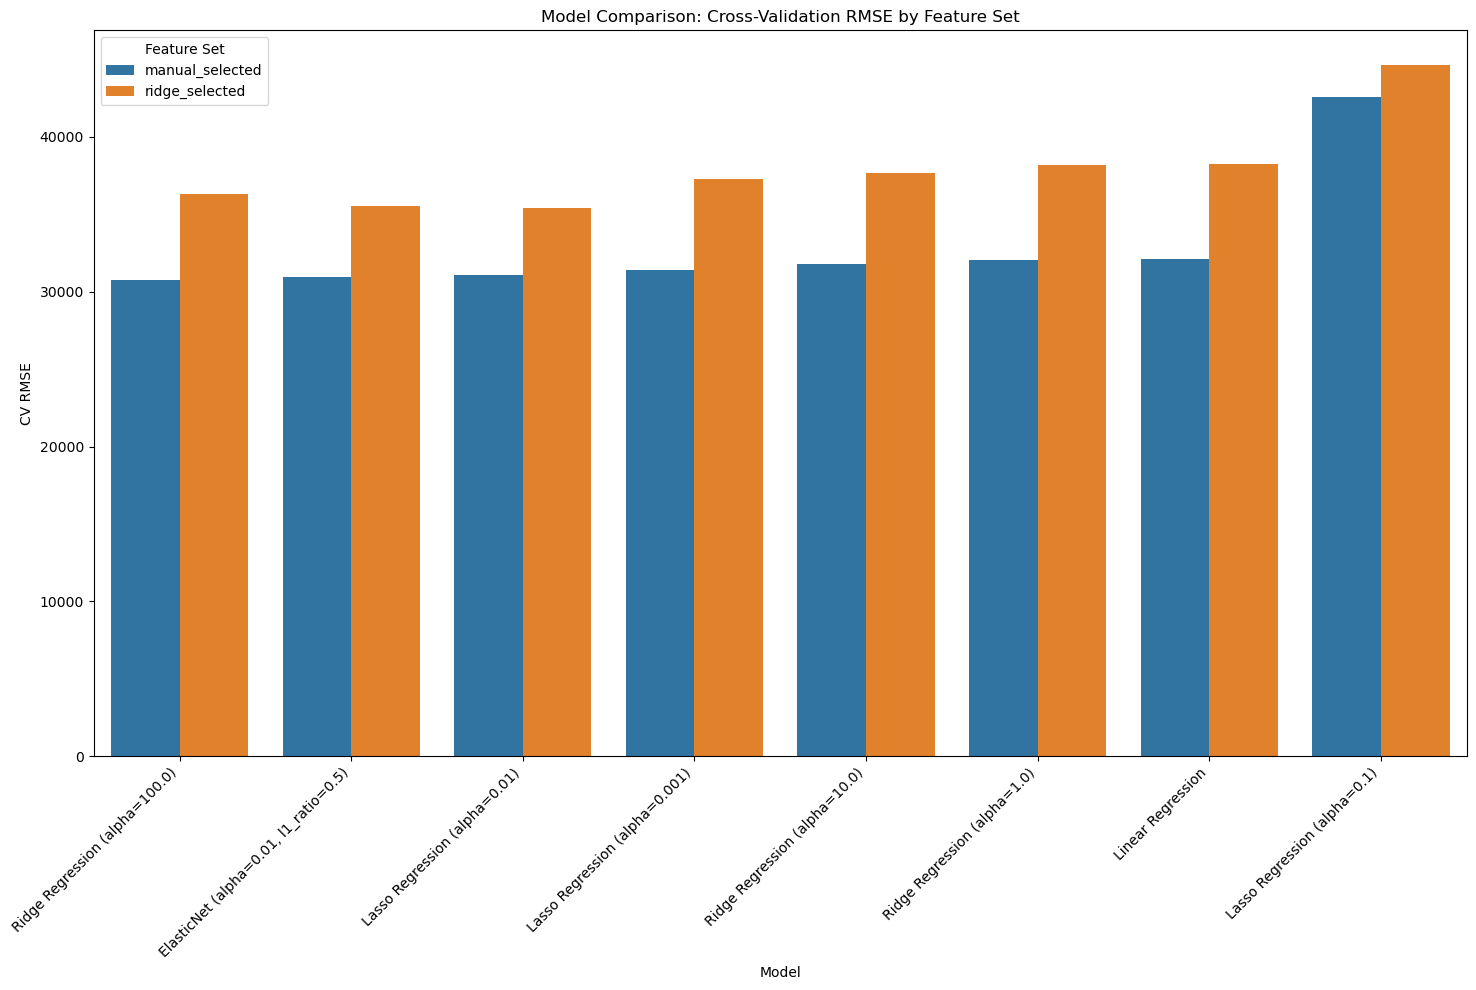

In [18]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='CV RMSE', hue='Feature Set', data=ranked_models)
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison: Cross-Validation RMSE by Feature Set')
plt.legend(title='Feature Set')
plt.tight_layout()
plt.savefig('../images/model_comparison.png')
plt.show()


## 7. Feature Importance Analysis for the Best Model


===== FEATURE IMPORTANCE ANALYSIS =====

Top 15 most important features:
                          Feature  Importance
2               num__log_total_sf    0.090794
0              num__overall_qual2    0.087962
3   num__neighborhood_price_level    0.048396
11              num__log_lot_area    0.044175
14           num__central_air_num    0.041143
1            num__log_gr_liv_area    0.036807
5            num__total_bathrooms    0.033216
7           num__kitchen_qual_num    0.031868
12             num__has_fireplace    0.031031
6                num__garage_cars    0.024347
10             num__bsmt_qual_num    0.012968
8             num__exter_qual_num    0.009439
9           num__living_area_qual   -0.004880
4                  num__house_age   -0.018083
13                 num__remod_age   -0.030874


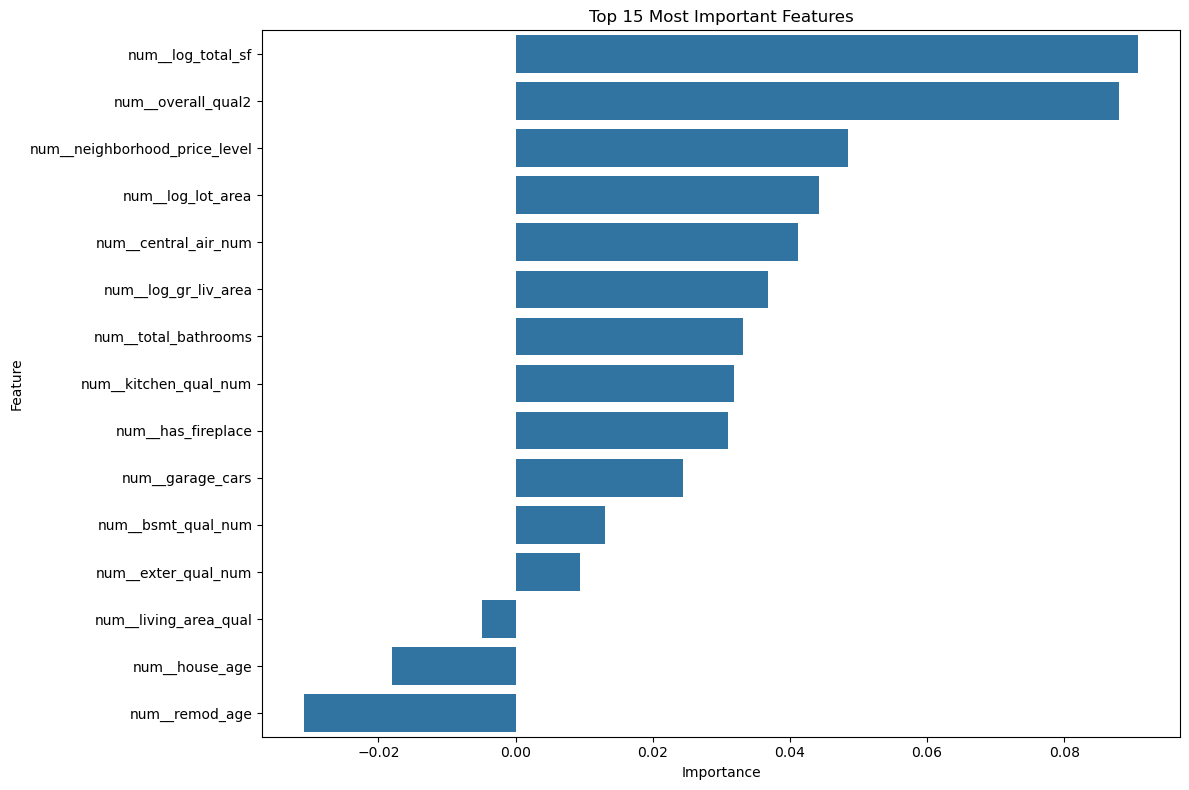

In [19]:

print("\n===== FEATURE IMPORTANCE ANALYSIS =====")

# Refit the best model on all training data
best_model.fit(feature_sets[best_feature_set]['X_train'], y_train)

# Try to get feature names and importance from the best model
try:
    # Get feature names after preprocessing
    if hasattr(best_model.named_steps['preprocessor'], 'get_feature_names_out'):
        # Sklearn 1.0+
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    else:
        # Manual approach for older sklearn versions
        num_features = feature_sets[best_feature_set]['numeric_features']
        cat_features = []
        
        # Check if we have categorical features and if 'cat' transformer exists
        if len(feature_sets[best_feature_set]['categorical_features']) > 0 and 'cat' in best_model.named_steps['preprocessor'].named_transformers_:
            cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
            if hasattr(cat_encoder, 'get_feature_names_out'):
                cat_features = cat_encoder.get_feature_names_out(
                    feature_sets[best_feature_set]['categorical_features']
                )
            else:
                cat_features = cat_encoder.named_steps['onehot'].get_feature_names_out(
                    feature_sets[best_feature_set]['categorical_features']
                )
        # Convert num_features to numpy array for concatenation
        num_features = np.array(num_features)
        
        # If we have categorical features, concatenate with numeric features
        if len(cat_features) > 0:
            feature_names = np.concatenate([num_features, cat_features])
        else:
            feature_names = num_features
    
    # Get coefficients from the model
    if hasattr(best_model.named_steps['model'], 'coef_'):
        coef = best_model.named_steps['model'].coef_
        
        # Create a DataFrame of feature importances
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': coef
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 15 most important features
        print("\nTop 15 most important features:")
        print(feature_importance.head(15))

        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Most Important Features')
        plt.tight_layout()
        plt.savefig('../images/feature_importance.png')
        plt.show()
except Exception as e:
    print(f"Error calculating feature importance: {e}")

In [20]:
feature_importance['Feature'].str.replace('num__','').to_list()

['log_total_sf',
 'overall_qual2',
 'neighborhood_price_level',
 'log_lot_area',
 'central_air_num',
 'log_gr_liv_area',
 'total_bathrooms',
 'kitchen_qual_num',
 'has_fireplace',
 'garage_cars',
 'bsmt_qual_num',
 'exter_qual_num',
 'living_area_qual',
 'house_age',
 'remod_age']

## 8. Visualizing predictions from the best model

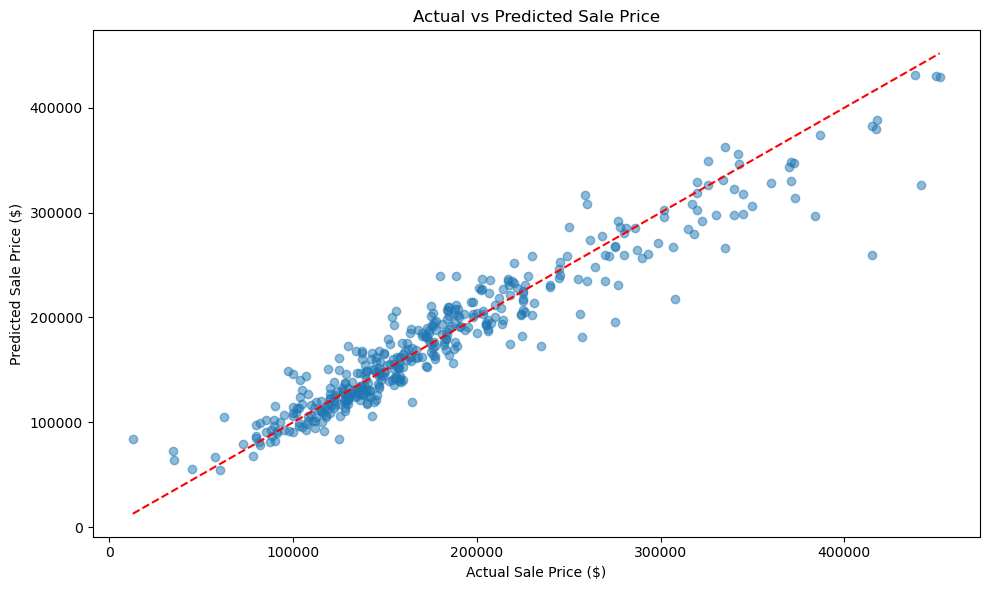

In [22]:
X_val_best = train_val_splits[best_feature_set]['X_val']
y_val_best = train_val_splits[best_feature_set]['y_val']

# Get predictions on validation set
# Visualization with original scale prices
val_pred_log = best_model.predict(X_val)
val_pred = np.expm1(val_pred_log)
y_val_orig = np.expm1(y_val)

plt.figure(figsize=(10, 6))
plt.scatter(y_val_orig, val_pred, alpha=0.5)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.xlabel('Actual Sale Price ($)')
plt.ylabel('Predicted Sale Price ($)')
plt.title('Actual vs Predicted Sale Price')
plt.tight_layout()
plt.show()

## 9. Checking residuals

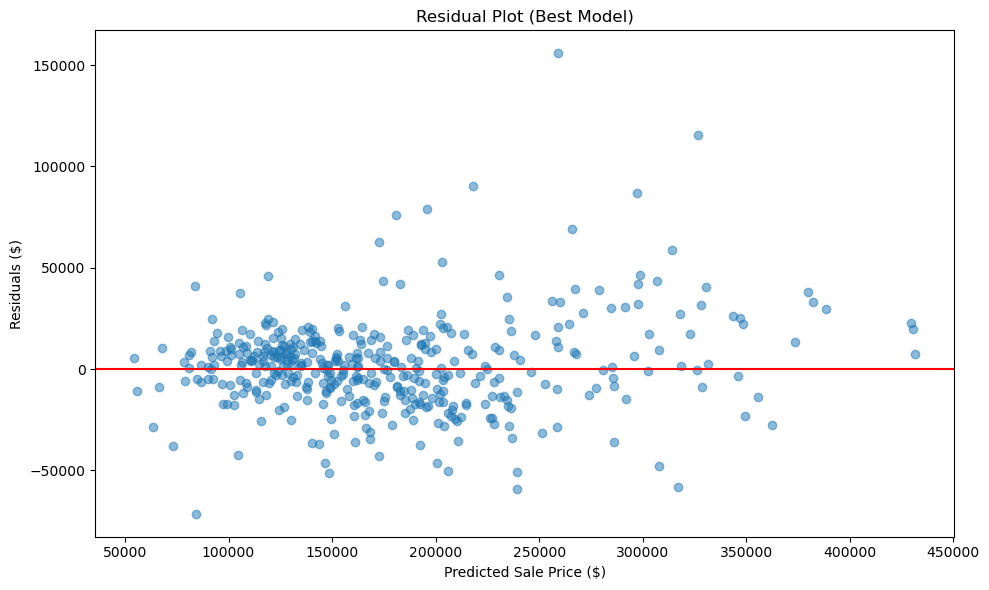

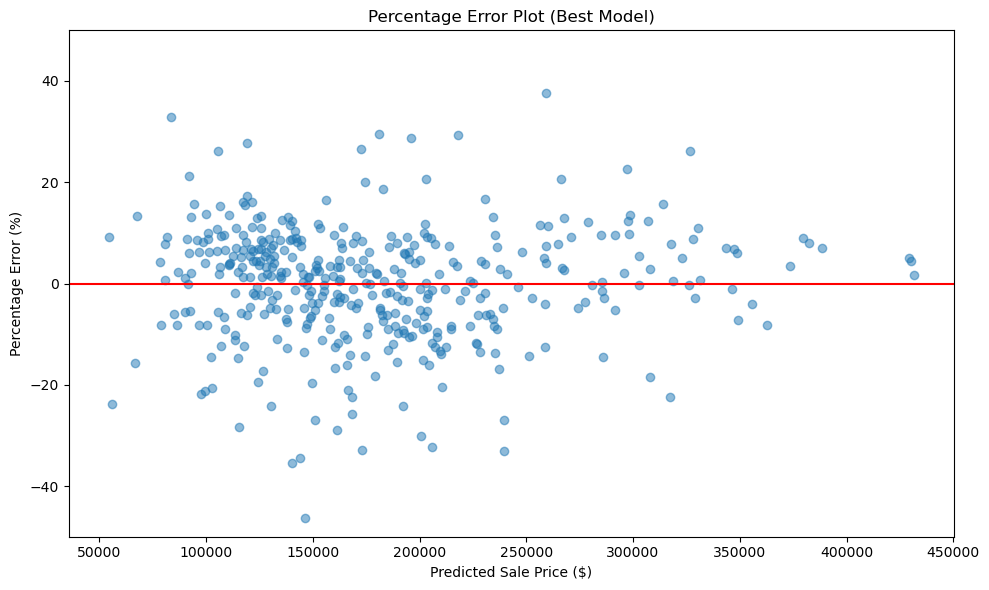

In [25]:
# Get predictions on validation set (log scale)
val_pred_log = best_model.predict(X_val_best)

# Transform back to original scale
val_pred = np.expm1(val_pred_log)
y_val_orig = np.expm1(y_val_best)

# Calculate residuals in original scale
residuals = y_val_orig - val_pred

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Sale Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot (Best Model)')
plt.tight_layout()
plt.savefig('../images/residuals.png')
plt.show()

# Optional: Also check for patterns in percentage errors
percent_error = (residuals / y_val_orig) * 100
plt.figure(figsize=(10, 6))
plt.scatter(val_pred, percent_error, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Sale Price ($)')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error Plot (Best Model)')
plt.ylim(-50, 50)  # Limit to ±50% for better visualization
plt.tight_layout()
plt.savefig('../images/percent_error.png')
plt.show()

## 10. Generate predictions on test set

In [24]:
# Back-transform predictions for final submission
test_predictions_log = best_model.predict(X_test)
test_predictions = np.expm1(test_predictions_log)

# Create submission file
submission = pd.DataFrame({
    'id': test_ID,
    'saleprice': test_predictions
})

# Save to CSV
submission.to_csv('../data/submission.csv', index=False)
print("Submission file created successfully!")

# 11. Save the best model
with open('../data/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Best model saved successfully!")

Submission file created successfully!
Best model saved successfully!


## 1. Setting Up Preprocessing Pipeline

This pipeline ensures consistent preprocessing of both training and test data.

- Handles any remaining missing values in numeric features by replacing them with the median
 - Standardizes numeric features to have mean 0 and standard deviation 1, which helps regression models converge faster
- Handles missing values in categorical features by using the most common value
- Converts categorical features to numeric using one-hot encoding
- Creates a single transformer that can be applied to new data at prediction time
- This approach is superior to manual preprocessing because it prevents data leakage and ensures test data is transformed based on training data statistics.

In [ ]:
# For numerical features: impute and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 2. Train-Validation Split

This creates a validation set to evaluate model performance on unseen data. By using 80% of the data for training and holding out 20% for validation, it is possible:

- Train the model on a substantial portion of the data
- Test its performance on data it hasn't seen before
- Get a more realistic estimate of how it will perform on new houses

The random_state=42 ensures reproducibility - to get the same split each time the code runs.

In [ ]:
X_train = X_train_reduced = X_train[selected_features]
X_test = X_test[selected_features]

X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size=0.2, 
                                                            random_state=42
                                                           )

print(f"Training subset shape: {X_train_main.shape}")
print(f"Validation subset shape: {X_val.shape}")

## 3. Defining Model Benchmark

This dictionary defines various regression models to test:

- Linear Regression: The baseline model with no regularization
- Ridge Regression: Adds L2 regularization, which reduces overfitting by penalizing large coefficients. Multiple alpha values are tested.
- Lasso Regression: Adds L1 regularization, which can perform feature selection by shrinking some coefficients to exactly zero. Multiple alpha values are tested.
- ElasticNet: A combination of L1 and L2 regularization, providing both feature selection and coefficient shrinkage.

Testing multiple models helps identify which approach works best for the data. The different alpha values represent different regularization strengths.

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge Regression (alpha=10.0)': Ridge(alpha=10.0),
    'Ridge Regression (alpha=100.0)': Ridge(alpha=100.0),
    'Lasso Regression (alpha=0.001)': Lasso(alpha=0.001),
    'Lasso Regression (alpha=0.01)': Lasso(alpha=0.01),
    'Lasso Regression (alpha=0.1)': Lasso(alpha=0.1),
}

## 4. Benchmark Models

The idea is:
- Tests each model with proper preprocessing
- Evaluate on the validation set using multiple metrics:

    - RMSE (Root Mean Squared Error): Prioritizes large errors
    - MAE (Mean Absolute Error): More robust to outliers
    - R² (Coefficient of determination): Percentage of variance explained

- Performs 5-fold cross-validation for a more robust performance estimate
- Store all results for comparison

Cross-validation is particularly important as it gives a more stable estimate of model performance by training and testing on different subsets of the data.

In [ ]:
# Benchmark the models
results = {}

for name, model in models.items():
    print(f"\nEvaluating: {name}")
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit on training subset
    pipeline.fit(X_train_main, y_train_main)
    
    # Evaluate on validation set
    val_pred = pipeline.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    print(f"  - Validation RMSE: ${val_rmse:.2f}")
    print(f"  - Validation MAE: ${val_mae:.2f}")
    print(f"  - Validation R²: {val_r2:.4f}")
    
    # Evaluate with cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, 
                                X_train, 
                                y_train, 
                                cv=kf, 
                                scoring='neg_root_mean_squared_error'
                               )
    
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"  - 5-Fold CV RMSE: ${cv_rmse:.2f} (±${cv_std:.2f})")
    
    # Store results
    results[name] = {
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'cv_rmse': cv_rmse,
        'cv_std': cv_std,
        'pipeline': pipeline
    }

## 5. Summarized Results

In [ ]:
# Summarized results
result_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation RMSE': [results[m]['val_rmse'] for m in results],
    'CV RMSE': [results[m]['cv_rmse'] for m in results],
    'Validation R²': [results[m]['val_r2'] for m in results]
})

print("=== Model Benchmark Results ===")
result_df.sort_values('CV RMSE')

## 6. Model Comparison Visualization

In [ ]:
#
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='CV RMSE', data=result_df.sort_values('CV RMSE'))
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison: Cross-Validation RMSE')
plt.tight_layout()
plt.show()

## 7. Selecting Best Model

In [ ]:
best_model_name = result_df.sort_values('CV RMSE').iloc[0]['Model']
best_model = results[best_model_name]['pipeline']
print(f"Best model: {best_model_name}")
print(f"CV RMSE: ${results[best_model_name]['cv_rmse']:.2f}")
print(f"Validation RMSE: ${results[best_model_name]['val_rmse']:.2f}")
print(f"Validation R²: {results[best_model_name]['val_r2']:.4f}")

## 8. Feature Importance Analysis

In [ ]:
# Refitting the best model on all training data
best_model.fit(X_train, y_train)

# Try to get feature names after preprocessing
try:
    feature_names = (
        numeric_features 
        # + list(best_model.named_steps['preprocessor']
        #      .named_transformers_['cat']
        #      .named_steps['onehot']
        #      .get_feature_names_out(categorical_features))
    )
    
    # Get coefficients from the model
    if hasattr(best_model.named_steps['model'], 'coef_'):
        coef = best_model.named_steps['model'].coef_
        
        # Create a DataFrame of feature importances
        feature_importance = pd.DataFrame({
            'Feature': feature_names, 
            'Importance': coef
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 15 most important features
        print("\nTop 15 most important features:")
        print(feature_importance.head(15))
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Most Important Features')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error calculating feature importance: {e}")

**Note**
This extracts and visualizes feature importance from the best model by:

- Obtaining feature names after preprocessing (including one-hot encoded features)
- Getting model coefficients (for linear models, the coefficient magnitude indicates importance)
- Visualizing the top 15 features by importance

This analysis is critical to real estate investors, as it shows which features drive home values the most.

## 9. Visualizing predicitons

In [ ]:
# Get predictions on validation set
val_pred = best_model.predict(X_val)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')
plt.tight_layout()
plt.show()

## 10. Checking residuals

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(val_pred, y_val - val_pred, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

**Note**

- Points should be randomly scattered around the zero line
- Patterns could indicate model problems (like heteroscedasticity or non-linearity)
- Large residuals identify homes the model struggles to price accurately

## 11. Generate predictions on test set

In [ ]:
#
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_ID,
    'saleprice': test_predictions
})

# Rename column if needed to match sample submission
if 'Id' in submission.columns and 'id' in sample_sub.columns:
    submission = submission.rename(columns={'Id': 'id'})

# Save to CSV
submission.to_csv('../data/submission.csv', index=False)
print("Submission file created successfully!")

In [ ]:
# Save the best tuned model
with open('../data/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)